<a href="https://colab.research.google.com/github/amitsaj94/Tesla-stock-price-forcasting/blob/main/Tesla_Stock_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
data = pd.read_csv('/content/TSLA.csv')
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [29]:
# check for the null values

data.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [30]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


# Plot all numerical features

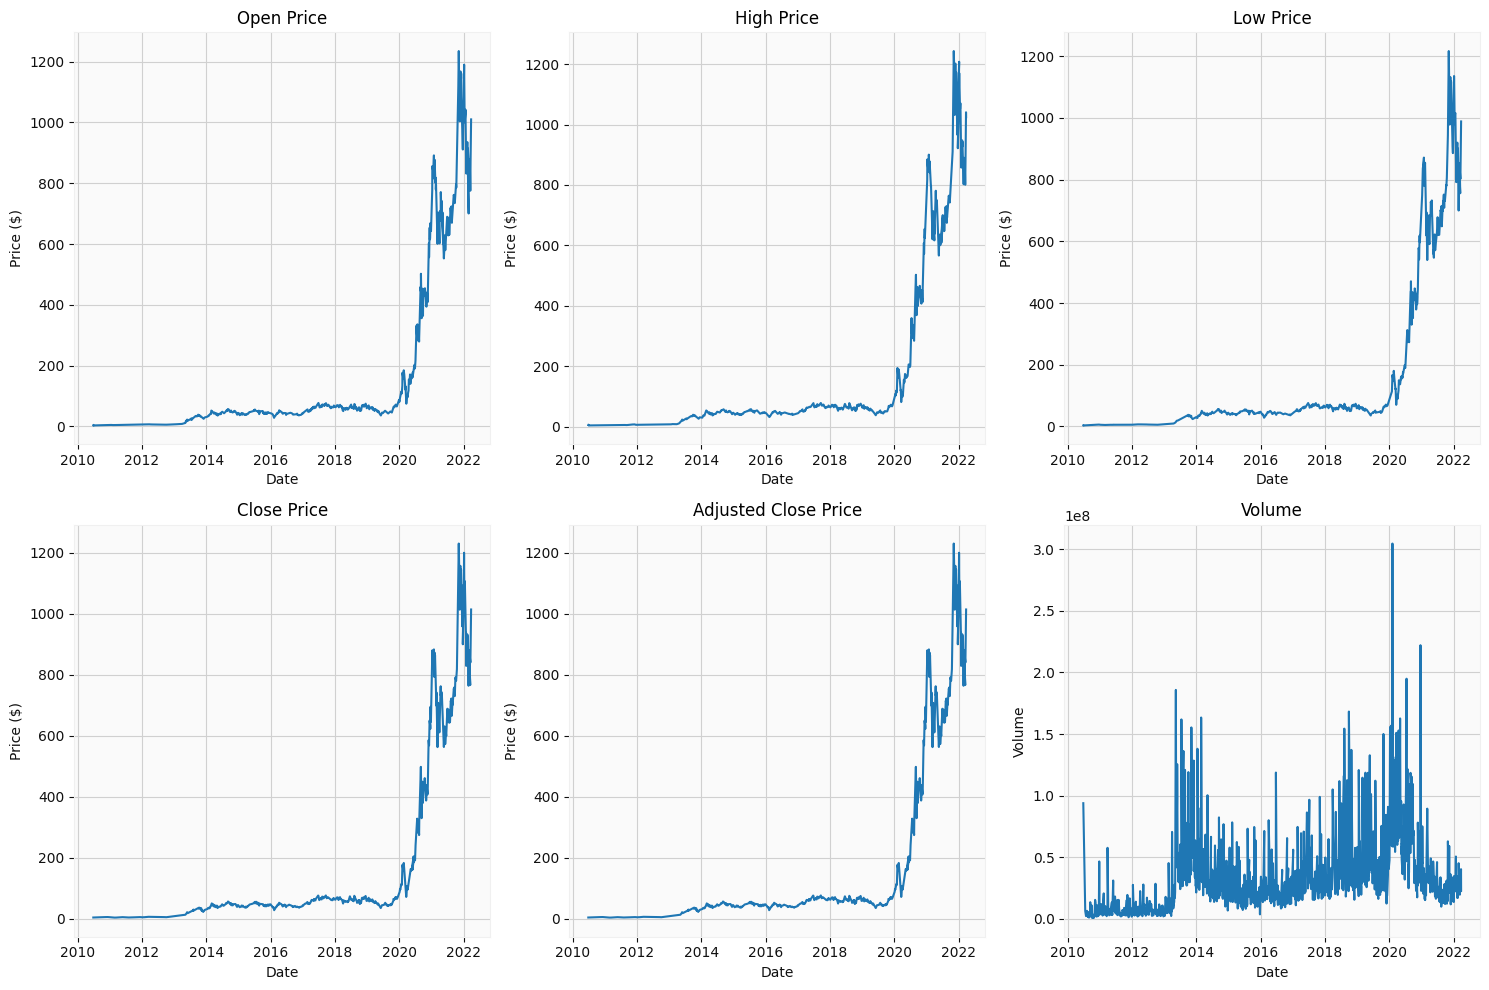

In [31]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Ensure datetime index
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

sns.lineplot(x=data.index, y=data['Open'], ax=ax[0,0])
ax[0,0].set_title('Open Price')
ax[0,0].set_ylabel('Price ($)')
ax[0,0].set_xlabel('Date')

sns.lineplot(x=data.index, y=data['High'], ax=ax[0,1])
ax[0,1].set_title('High Price')
ax[0,1].set_ylabel('Price ($)')
ax[0,1].set_xlabel('Date')

sns.lineplot(x=data.index, y=data['Low'], ax=ax[0,2])
ax[0,2].set_title('Low Price')
ax[0,2].set_ylabel('Price ($)')
ax[0,2].set_xlabel('Date')

sns.lineplot(x=data.index, y=data['Close'], ax=ax[1,0])
ax[1,0].set_title('Close Price')
ax[1,0].set_ylabel('Price ($)')
ax[1,0].set_xlabel('Date')

sns.lineplot(x=data.index, y=data['Adj Close'], ax=ax[1,1])
ax[1,1].set_title('Adjusted Close Price')
ax[1,1].set_ylabel('Price ($)')
ax[1,1].set_xlabel('Date')

sns.lineplot(x=data.index, y=data['Volume'], ax=ax[1,2])
ax[1,2].set_title('Volume')
ax[1,2].set_ylabel('Volume')
ax[1,2].set_xlabel('Date')

# Avoid overlapping labels
plt.tight_layout()
plt.show()


# Overall Insights:

- Tesla's stock price showed a long period of relative stability followed by an exponential rise in recent years.

- The volume spikes correlate with the price surge phases, suggesting increased trader interest and possibly volatility.

- The price and volume patterns are typical of a growth stock experiencing accelerated investor demand.

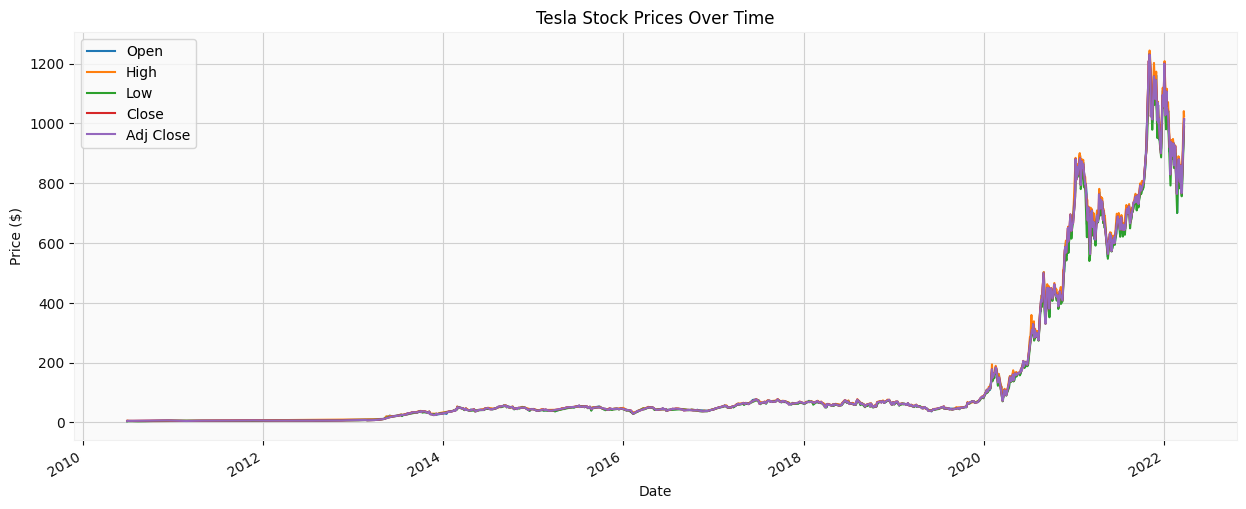

In [32]:
data.plot(y=['Open', 'High', 'Low', 'Close', 'Adj Close'], figsize=(15,6))
plt.title("Tesla Stock Prices Over Time")
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

The close alignment of price metrics underlines typical daily trading ranges.

The plot provides the overall price movement context for deeper analysis like forecasting, volatility, or volume studies.

# Daily Returns & Log Returns
**- Understand volatility and distribution of returns:**

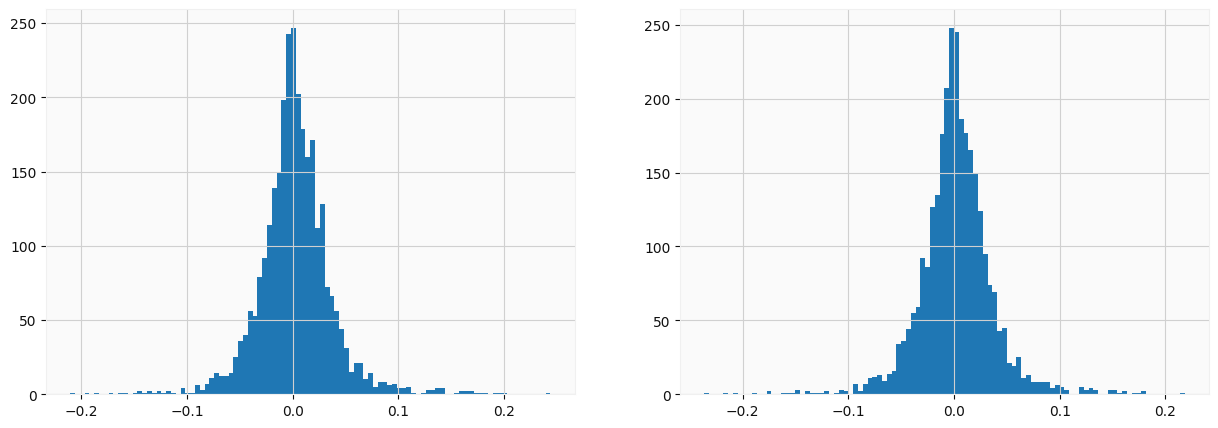

In [33]:
# Simple return
data['simple_returns'] = data['Adj Close'].pct_change()

# Log return
data['log_returns'] = np.log(data['Adj Close']).diff()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
data['simple_returns'].hist(bins=100, ax=ax[0])
data['log_returns'].hist(bins=100, ax=ax[1])
plt.show()


# Volatility Analysis¶
**- Rolling statistics to see changing trends & risk:**

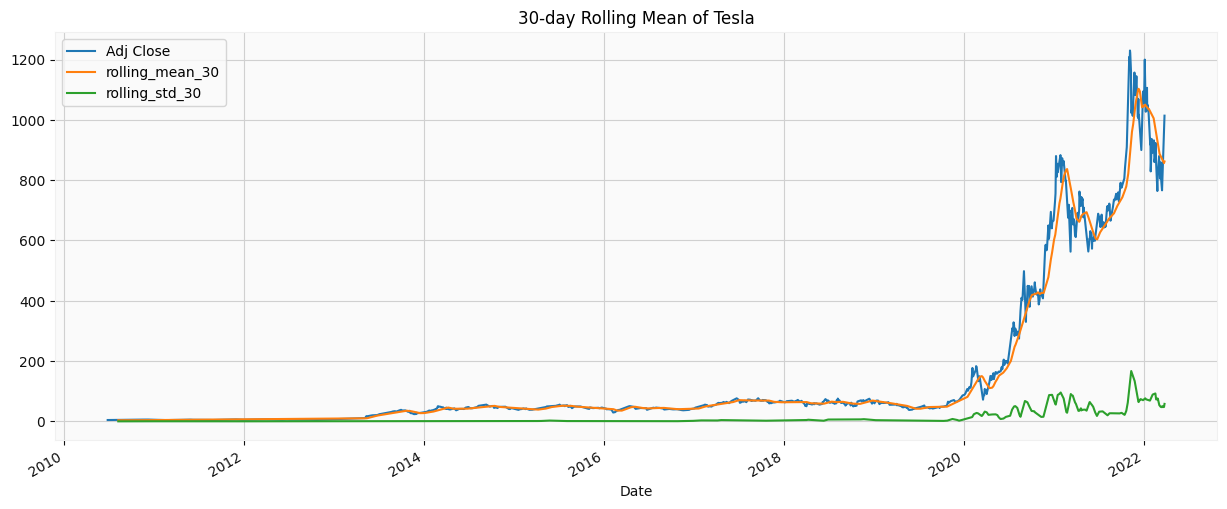

In [34]:
data['rolling_mean_30'] = data['Adj Close'].shift(1).rolling(30).mean()
data['rolling_std_30'] = data['Adj Close'].shift(1).rolling(30).std()

data[['Adj Close', 'rolling_mean_30', 'rolling_std_30']].plot(figsize=(15,6))
plt.title("30-day Rolling Mean of Tesla")
plt.show()


# Insights:

- The rolling mean closely follows the adjusted close price, smoothing abrupt fluctuations and revealing longer-term trends.

- During the initial phase, the stock price was relatively stable, and rolling STD was low, indicating little price volatility.

- As the stock price surged starting about 2019-2020, volatility (rolling STD) also increased significantly, reflecting more unstable and rapid price changes.

- The rising rolling STD indicates more uncertainty or risk in the stock price during that period.

- The rolling mean helps identify the underlying trend amidst such volatility.

# Correlation Analysis
**- Between OHLC and Volume**:

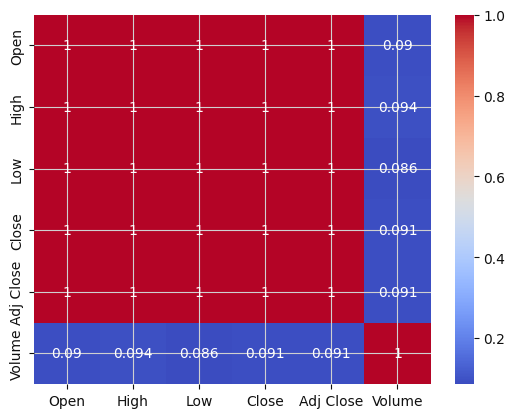

In [35]:
col = data[['Open','High','Low','Close','Adj Close','Volume']].corr()
sns.heatmap(col, annot=True, cmap='coolwarm')
plt.show()

# Insights

Perfect Correlation Among Price Metrics: The most prominent feature is the deep red block with values of 1. This indicates that the Open, High, Low, Close, and Adjusted Close prices are almost perfectly correlated with each other. This is expected, as these values all represent the price of a stock on a single day, so they move together in lockstep.

Weak Correlation with Volume: The bottom row and rightmost column show a very different story. The correlation values between Volume and all the other price metrics are very low (ranging from 0.086 to 0.094). This means that there is no linear relationship between a stock's price and its trading volume. High prices don't necessarily mean high volume, and low prices don't mean low volume.

# Candlestick Chart
**- Shows Open, High, Low, Close patterns:**

In [17]:
pip install mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.2 MB/s eta 0:00:00


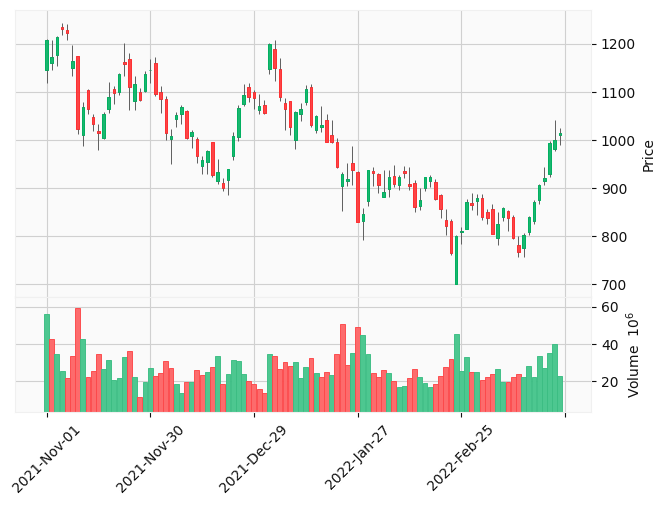

In [36]:
import mplfinance as mpf
mpf.plot(data[-100:], type='candle', volume=True, style='yahoo')


# Insights

1. The Price Trend

- Downtrend: From early November 2021 to late February 2022, the stock was in a clear downtrend. The price consistently fell from over 1200 to below 700. This period is dominated by red candlesticks, which means the price closed lower than it opened on most days.

- Reversal: Around late February 2022, the trend sharply reversed. The price started a strong uptrend, characterized by a series of tall green candlesticks. This shows a significant shift in market sentiment from selling to buying.

2. The Trading Volume

- Selling Pressure: The initial price decline from November to December was accompanied by high trading volume (tall red bars). This suggests that the downtrend was driven by strong selling pressure.

- Buying Interest: The more recent price increase (late February to March) is also happening on high volume (tall green bars). This is a bullish sign, as it indicates that the upward movement is supported by strong buying interest and is more likely to be sustained.

# Seasonality & Trend
**- Resample weekly/monthly to observe trend:**

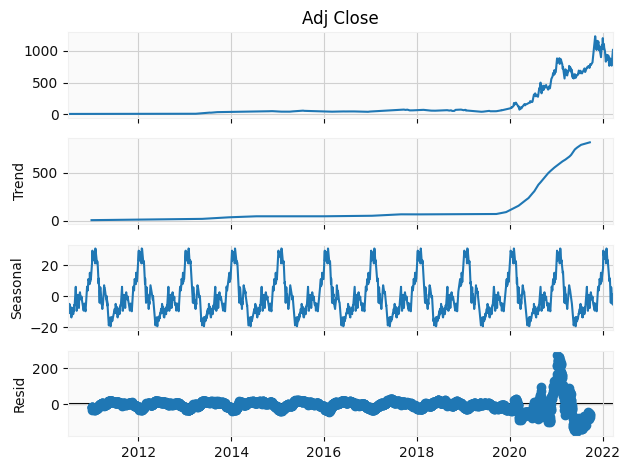

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Adj Close'], model = 'Additive', period = 252)

result.plot()
plt.tight_layout()
plt.show()

# Insights:

- **Observed (Adj Close):** The top plot shows the raw data. It reveals that the stock price was relatively stable and low from 2011 to late 2019. After that, it experienced a dramatic and rapid increase, reaching a peak around 2021 before becoming highly volatile.

- **Trend:** This component captures the long-term direction of the price. It mirrors the observed data, showing a flat trend for many years followed by an extremely steep upward trend starting in late 2019. This indicates a period of explosive and sustained growth.

- **Seasonal:** This plot shows a clear and consistent annual pattern of price fluctuations. The repeating waves demonstrate a strong, predictable seasonality. This pattern likely corresponds to recurring yearly events that affect the stock, such as holiday spending cycles or annual corporate announcements.

- **Residuals (Resid):** This is the remaining noise after the trend and seasonal patterns have been removed. For most of the period (2011-2019), the residuals are small and random, which means the trend and seasonality largely explain the data. However, starting in late 2020, the residuals become much larger and more volatile, suggesting that a significant amount of the price fluctuation during this period was due to unpredictable, one-off events that the trend and seasonality cannot explain.

# Volume vs Price Relationship
**- Scatter plot to see if high volume affects price:**

<Axes: xlabel='Volume', ylabel='Adj Close'>

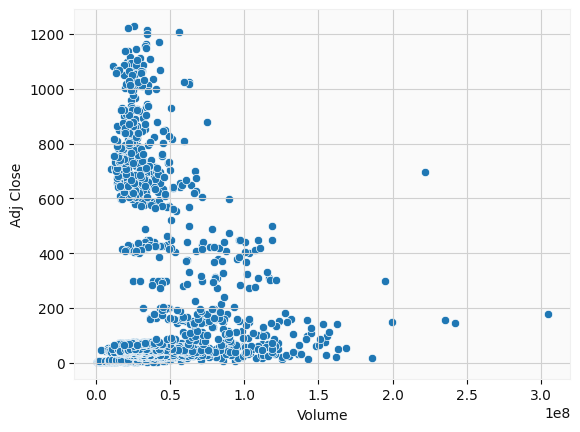

In [38]:
sns.scatterplot(x='Volume', y='Adj Close', data=data)


# Insights:

- No Linear Correlation: There is no clear linear relationship between price and volume. The data points are scattered widely, meaning high volume doesn't reliably correspond to high prices, and vice versa. This reinforces the finding from the correlation heatmap.

- Low Volume, High Volatility: On days with low trading volume (the dense cluster of points on the far left), the price is extremely volatile. The price can be found at any level, from near zero to over 1200. This suggests that on typical, quiet trading days, the stock's price is highly unpredictable.

- High Volume, Lower Prices: The plot also reveals an interesting pattern: there are several data points with very high volume, but they tend to correspond to lower prices. There are no data points with both extremely high volume and extremely high prices (the top-right quadrant is empty). This could indicate that significant events that cause large sell-offs are also what drive trading volume to its highest levels.

# Autocorrelation
**- See if past values predict future:**

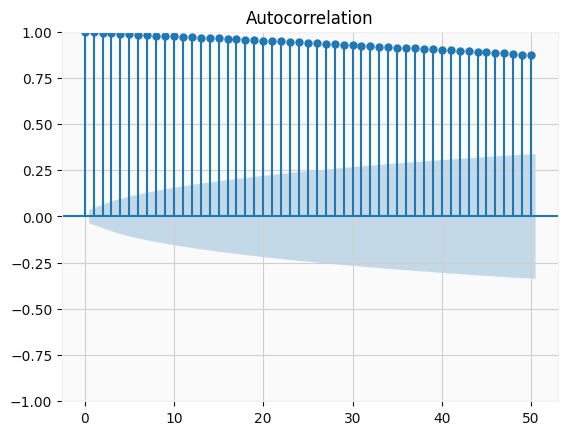

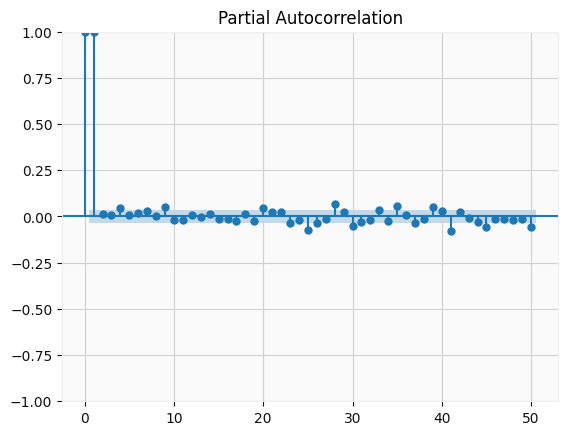

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Adj Close'].dropna(), lags=50)
plot_pacf(data['Adj Close'].dropna(), lags=50)
plt.show()


# Insights:

1. Autocorrelation Plot (ACF)
The top plot shows the correlation of the time series with itself at different lags (past time steps).

- Interpretation: The correlation is very high at lag 1 and decays very slowly over time. The correlation bars stay well above the blue confidence interval for many lags. This is the classic signature of a non-stationary time series. It indicates a very strong trend in the data, where each value is highly dependent on the previous one. This confirms that the data has a clear, long-term direction.

2. Partial Autocorrelation Plot (PACF)
The bottom plot shows the correlation of the time series with its lagged values, but with the effects of all the intermediate lags removed.

- Interpretation: The partial autocorrelation is very high at lag 1 but drops off sharply at all subsequent lags. This indicates that the correlation at lags 2, 3, and so on is simply a result of the strong correlation at lag 1. This is the classic signature of a series that requires first-order differencing to remove the trend.

In [40]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'simple_returns',
       'log_returns', 'rolling_mean_30', 'rolling_std_30'],
      dtype='object')

# **USING FACEBOOK PROPHET MODEL**

# Let's do some feature engineering

In [139]:
# --- 1. Data Preparation and Feature Engineering ---

prophet_df = data.reset_index()[['Date', 'Adj Close', 'Volume', 'simple_returns', 'log_returns']].rename(
    columns={'Date': 'ds', 'Adj Close': 'y'}
)

# Engineer time-based features and lag features

prophet_df['y_orig'] = prophet_df['y']
prophet_df['y'] = np.log(prophet_df['y'])
prophet_df['y_lag1'] = prophet_df['y'].shift(1)
prophet_df['y_lag2'] = prophet_df['y'].shift(2)
prophet_df['rolling_mean_4d'] = prophet_df['y'].rolling(window=4).mean().shift(1)
prophet_df['rolling_mean_14'] = prophet_df['y'].shift(1).rolling(14).mean()
prophet_df['rolling_std_14'] = prophet_df['y'].shift(1).rolling(14).std()
prophet_df['volatility_30'] = prophet_df['y'].shift(1).rolling(30).std()



# Drop rows with NaN values created by lag and rolling operations

prophet_df = prophet_df.dropna().copy()


# Train test split¶
- testing on last one year data

In [140]:
train_df = prophet_df[:-365].copy()
test_df = prophet_df[-365:].copy()

In [141]:
# Define regressors that are NOT future dependent

REGRESSORS = ['y_lag1', 'y_lag2', 'rolling_mean_4d','rolling_mean_14', 'rolling_std_14','volatility_30' ]

# Fit Prophet with regressors

In [142]:
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
for r in REGRESSORS:
    model.add_regressor(r)
model.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_qjajk/03vbg17y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_qjajk/iudgifem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19252', 'data', 'file=/tmp/tmplw_qjajk/03vbg17y.json', 'init=/tmp/tmplw_qjajk/iudgifem.json', 'output', 'file=/tmp/tmplw_qjajk/prophet_model6fyamb15/prophet_model-20250922063025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [143]:
# Forecasting on the Test Set
# Create a future dataframe for the test set

future = test_df[['ds'] + REGRESSORS].copy()

# Forecast
forecast = model.predict(future)

# Ensure both test_df and forecast have the same index for alignment
test_df = test_df.reset_index(drop=True)
forecast = forecast.reset_index(drop=True)

# Reverse log transform for both actual and forecast
test_df['y_pred'] = np.exp(forecast['yhat'])
test_df['y_actual'] = np.exp(test_df['y'])

# Evaluate on the original scale
rmse = np.sqrt(mean_squared_error(test_df['y_actual'], test_df['y_pred']))
mae = mean_absolute_error(test_df['y_actual'], test_df['y_pred'])
print("\n Model Evaluation")
print("RMSE:", rmse)
print("MAE:", mae)


 Model Evaluation
RMSE: 30.202388467879842
MAE: 21.24617405877336


# Model Evaluation & Insights

RMSE = 30.20 → On average, predictions deviate by about $30 from actual closing prices.

MAE = 21.25 → The average absolute daily error is about $21.

Given Tesla’s trading range (~$200–$400), this corresponds to an error of roughly 7–12%, which is competitive for financial time series modeling.

# Graph Plot

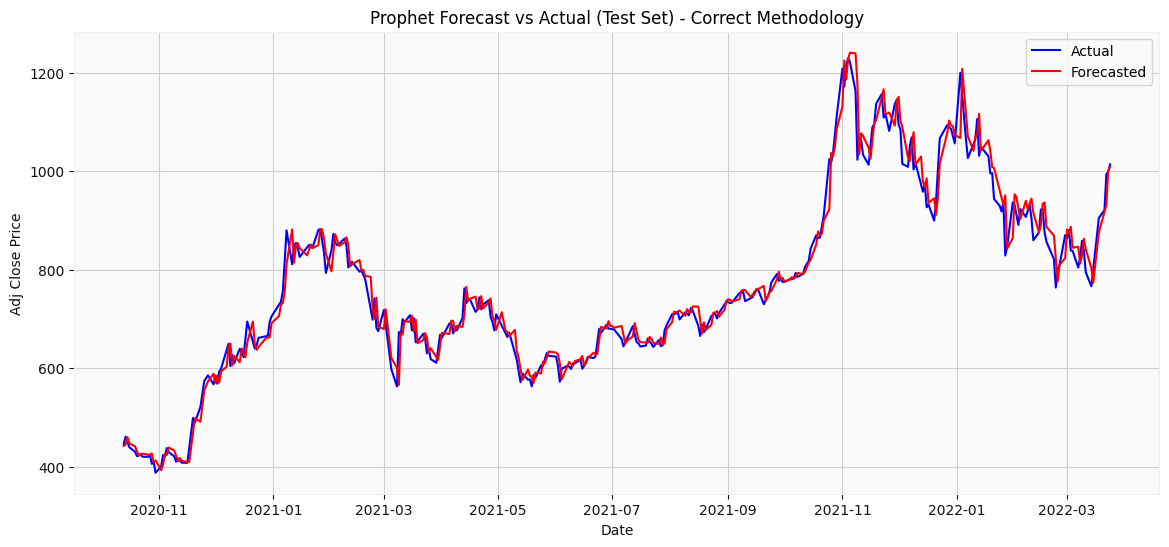

In [144]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(test_df['ds'], test_df['y_actual'], label='Actual', color='blue')
plt.plot(test_df['ds'], test_df['y_pred'], label='Forecasted', color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Adj Close Price")
plt.title("Prophet Forecast vs Actual (Test Set) - Correct Methodology")
plt.show()

# Insights


**Trend Capture:**

The model (red line) closely follows the actual Tesla stock prices (blue line) over the one-year test period. This demonstrates that Prophet, when enhanced with lag-based regressors, can effectively model overall price trends and medium-term dynamics.

**Accuracy:**

With an RMSE of ~$30 and MAE of ~$21, the model maintains predictions within ~7–12% of the actual stock price range. This indicates good performance for such a volatile asset.

**Volatility Handling:**

The forecast replicates general upward and downward swings, but it smooths out sharp price spikes (e.g., around late 2021 peaks). This highlights Prophet’s strength in capturing trends but also its limitation in highly stochastic, short-term market fluctuations.

**Methodological Soundness:**

Unlike naive forecasting attempts, this model avoids data leakage by using only lagged features (y_lag1, y_lag2, rolling means). This ensures predictions rely solely on information available at the time of forecasting.

**Practical Value:**

The results show that while exact daily prices are difficult to forecast, the model is effective for directional insight, trend following, and risk-awareness applications, rather than precise intraday trading.

In [146]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,y_lag2,y_lag2_lower,y_lag2_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-13,1.724176,6.049724,6.136417,1.724176,1.724176,4.367817,4.367817,4.367817,1.631557,...,0.068461,0.068461,0.068461,-0.003169,-0.003169,-0.003169,0.0,0.0,0.0,6.091993
1,2020-10-14,1.724211,6.052539,6.141231,1.724211,1.724211,4.374761,4.374761,4.374761,1.631557,...,0.068948,0.068948,0.068948,-0.002677,-0.002677,-0.002677,0.0,0.0,0.0,6.098972
2,2020-10-15,1.724246,6.090612,6.176463,1.724246,1.724246,4.407346,4.407346,4.407346,1.631557,...,0.069200,0.069200,0.069200,-0.002137,-0.002137,-0.002137,0.0,0.0,0.0,6.131592
3,2020-10-16,1.724281,6.058457,6.144757,1.724281,1.724281,4.379448,4.379448,4.379448,1.631557,...,0.070029,0.070029,0.070029,-0.001557,-0.001557,-0.001557,0.0,0.0,0.0,6.103729
4,2020-10-19,1.724386,6.045904,6.133599,1.724386,1.724386,4.366174,4.366174,4.366174,1.631557,...,0.069327,0.069327,0.069327,0.000316,0.000316,0.000316,0.0,0.0,0.0,6.090560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022-03-18,1.742401,6.731188,6.821706,1.733550,1.750902,5.033083,5.033083,5.033083,1.631557,...,0.085435,0.085435,0.085435,-0.006602,-0.006602,-0.006602,0.0,0.0,0.0,6.775483
361,2022-03-21,1.742506,6.775938,6.866530,1.733630,1.751033,5.077556,5.077556,5.077556,1.631557,...,0.086376,0.086376,0.086376,-0.004940,-0.004940,-0.004940,0.0,0.0,0.0,6.820061
362,2022-03-22,1.742541,6.795567,6.884552,1.733640,1.751099,5.093811,5.093811,5.093811,1.631557,...,0.087354,0.087354,0.087354,-0.004301,-0.004301,-0.004301,0.0,0.0,0.0,6.836352
363,2022-03-23,1.742576,6.863767,6.953630,1.733650,1.751169,5.166115,5.166115,5.166115,1.631557,...,0.087797,0.087797,0.087797,-0.003634,-0.003634,-0.003634,0.0,0.0,0.0,6.908691


In [147]:
final_df = pd.DataFrame(forecast)
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(y=test_df['y_actual'], name= 'Actual')
predict_chart = go.Scatter(y=test_df['y_pred'], name= 'Predicted')
predict_chart_upper = go.Scatter(y=np.exp(final_df["yhat_upper"]), name= 'Predicted Upper')
predict_chart_lower = go.Scatter(y=np.exp(final_df["yhat_lower"]), name= 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'